# Research Question 2: Output Diversification

## Important notes

#### Download required files stored in Google Drive
This script requires the file `inverted_index.json` and `tweets_with_authority.csv` that can be downloaded from the Google Drive Folder (`https://drive.google.com/drive/u/1/folders/16I4_ZCre59ufD9lDZbFK9cn1mALRmPjB`). The files must be stored in the `~/data` folder as specified in the README.

In [184]:
import sys
import pickle
import numpy as np
sys.path.append('../')
import pandas as pd
from utils import *
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import json
import csv
MODES = [1,2]

In [2]:
INPUT_PATH = '../data/'
AUTHORITY_DATASET = "tweets_with_authority.csv"
INVERTED_INDEX = "inverted_index.json"
VECTORIZER = "vectorizer.pickle"
MODES = ['1', '2']

In [3]:
class TwitterSearch:
    def __init__(self):
        self.data, self.corpus, self.vectorizer, self.inverted_index = self._load_information()

    def _load_information(self):
        # Load pretrained vectorizer
        vectorizer = pickle.load(open(INPUT_PATH + 'vectorizer.pickle', "rb"))

        # Load corpus
        df = pd.read_csv(INPUT_PATH +'tweets_with_authority.csv')
        corpus = df['clean_text']
        corpus = corpus.fillna('')
        corpus = vectorizer.transform(corpus)
        
        with open(INPUT_PATH + INVERTED_INDEX, 'r') as f:
            inverted_index = json.load(f)

        return df, corpus, vectorizer, inverted_index

    def _get_tweet_fields(self, i):
        """
        Returns the relevant fields for each tweet
        i: id of the tweet we want to extract the information
        returns various fields needed for showing the result to the user
        """
        df = self.data
        user_name = eval(df.iloc[i]['user'])['name']
        text = df.iloc[i]['full_text']
        entities = eval(df.iloc[i]['entities'])
        urls = entities['urls']
        if urls:
            url = urls[0]['url']
            text = text.replace(url, '')
        else:
            url = 'No url'

        hashtags = entities['hashtags']

        if not hashtags:
            hashtags = 'No hashtags'

        favorite_count = df.iloc[i]['favorite_count']
        retweet_count = df.iloc[i]['retweet_count']
        followers_count = df.iloc[i]['followers_count']

        return user_name, text, url, hashtags, favorite_count, retweet_count, followers_count

    def find_full_match_docs(self, query):
        """
        Return the indexes of the documents containing all terms in the query
        """
        docs = None

        for word in query.split():
            if docs is None:
                docs = set([i[0] for i in self.inverted_index[word]])
            else:
                docs = docs.intersection(set([i[0] for i in self.inverted_index[word]]))
        return list(self.data[self.data['id_str'].isin(docs)].index)

    
    def return_top_n_doc(self,query,n,show = True,authority = None):
        """
        query: Query that the user writes.
        tf_idf: dataframe containing tfidf weights for each word in each doc
        n: number of doc to return to the user
        show: if you want to visualize the results

        returns a list with the most top n relevant tweets
        """
        assert n>0, "n should be a positive integer"
        query = clean_text(query) #noramalize the query
        query_vec = self.vectorizer.transform([query]) #calculate tdidf
        results = cosine_similarity(self.corpus, query_vec)
        results = results.flatten()

        documents_retrieved = []

        #######Return the results#########
        rank=0

        if authority is not None:
            results = 3*results*0.5*authority

        # Reverse the results
        results = results.argsort()[::-1]

        ## Generate print mask for results

        # The mask will contain the indexes from the results array in printing order
        # By default this mask will be the first n results of our cosine similarity output
        mask = [i for i in range(n)]

        # We find those documents that contain all the terms in the query
        full_matches = np.array(self.find_full_match_docs(query))

        # If we have more full matches than desired results, we just use them in order to print
        if len(full_matches)>=n:
            mask = list(np.where(np.isin(results, full_matches))[0])

        elif len(full_matches)==0:
            pass    
        # If not, we will include first those with full match and the remaining ones will be ordered
        # simply by cosine similarity
        else:
            full_rank = 0

            for i in range(len(results)):
                if results[i] in full_matches:
                    # Insert the full matches at the beggining to preserve the order of the remaining results
                    mask.insert(full_rank, i) 
                    full_rank+=1

        # Ensure we will only print n results
        mask = mask[:n]

        # Print following the order determined by the mask
        for i in mask:
            i = int(i)
            user_name, text, url, hashtags, favorites, retweets, followers = self._get_tweet_fields(results[i])
            if show == True:
                print("-->",rank + 1)
                print(text," | ",user_name," | ",self.data.iloc[results[i]]['created_at']," | ", hashtags[:] ," | ",favorites," | ", retweets," | ",url, " | ", followers)
            
            documents_retrieved.append(results[i])
            rank +=1

        return documents_retrieved

    def query(self, query, n=20, authority=None):
        self.return_top_n_doc(query, n, authority)

    def interface(self):
        while True:
            n = int(input("Enter the desired number of results: "))
            assert n>0, "The number of results must be a positive integer number"
            while True:
                mode = str(input("""Which mode would you like to use (insert number for the desired option)\n1: TF-IDF\n2: TF-IDF and authority\n"""))
                
                if mode in MODES:
                    break
                else:
                    print("Please insert some of these options: {}".format(', '.join(MODES)))

            query = input("Enter your query: ")
            if mode == "1":
                self.query(query, n)
            elif mode == "2":
                self.query(query, n, authority=True)

In [4]:
class TwitterSearch_Adapted(TwitterSearch):
    def __init__(self,SAMPLE_SIZE):
        self.data, self.corpus, self.vectorizer, self.inverted_index = self._load_information(SAMPLE_SIZE)

    def _load_information(self, SAMPLE_SIZE): # We introduce a sample size
        # Load pretrained vectorizer
        vectorizer = pickle.load(open(INPUT_PATH + 'vectorizer.pickle', "rb"))

        # Load corpus
        df = pd.read_csv(INPUT_PATH +'tweets_with_authority.csv')[:SAMPLE_SIZE]
        corpus = df['clean_text']
        corpus = corpus.fillna('')
        corpus = vectorizer.transform(corpus)
        
        with open(INPUT_PATH + INVERTED_INDEX, 'r') as f:
            inverted_index = json.load(f)

        return df, corpus, vectorizer, inverted_index
    
    def return_top_n_doc(self,query,n,c_labels = {},show = True, authority = None): # also returns clusters assigned to each doc
        """
        query: Query that the user writes.
        tf_idf: dataframe containing tfidf weights for each word in each doc
        n: number of doc to return to the user
        show: if you want to visualize the results

        returns a list with the most top n relevant tweets
        """
        assert n>0, "n should be a positive integer"
        query = clean_text(query) #noramalize the query
        query_vec = self.vectorizer.transform([query]) #calculate tdidf
        results = cosine_similarity(self.corpus, query_vec)
        results = results.flatten()

        documents_retrieved = []

        #######Return the results#########
        rank=0

        if authority is not None:
            results = 3*results*0.5*authority
            
        similarities = results.copy()
        sim_dict = {}
        
        max_similarity = results.max()

        # Reverse the results
        results = results.argsort()[::-1]

        ## Generate print mask for results

        # The mask will contain the indexes from the results array in printing order
        # By default this mask will be the first n results of our cosine similarity output
        mask = [i for i in range(n)]

        # We find those documents that contain all the terms in the query
        full_matches = np.array(self.find_full_match_docs(query))

        # If we have more full matches than desired results, we just use them in order to print
        if len(full_matches)>=n:
            mask = list(np.where(np.isin(results, full_matches))[0])

        elif len(full_matches)==0:
            pass

        # If not, we will include first those with full match and the remaining ones will be ordered
        # simply by cosine similarity
        else:
            mask = [i for i in mask if results[i] not in full_matches]
            full_rank = 0
            for i in range(len(results)):
                if results[i] in full_matches:
                    # Insert the full matches at the beggining to preserve the order of the remaining results
                    mask.insert(full_rank, i) 
                    full_rank+=1

        # Ensure we will only print n results
        mask = mask[:n]

        # Print following the order determined by the mask
        #Cluster representation list and rank
        clusters_res = []
        for i in mask:
            i = int(i)
            user_name, text, url, hashtags, favorites, retweets, followers = self._get_tweet_fields(results[i])
            if show == True:
                print("-->", rank + 1)
                print(text," | ",user_name," | ",self.data.iloc[results[i]]['created_at']," | ", hashtags[:] ," | ",favorites," | ", retweets," | ",url, " | ", followers)
            
            documents_retrieved.append(results[i])
            
            # --- STORE SIMILARITY INFORMATION --- #
            if rank<len(full_matches):
                sim_dict[str(results[i])] = max_similarity+0.1*max_similarity*(1/(rank+1))
            else:
                sim_dict[str(results[i])] = similarities[results[i]]
                
            
            #----OBTAIN CLUSTER INFORMATION----#
            if c_labels:
                c = c_labels[results[i]]
                if show:
                    print('Cluster:', c)
                    print()

                clusters_res.append(c)
            
            rank +=1
            
        return documents_retrieved, clusters_res, sim_dict

#### Load cluster information from the previous research question RQ1

In [5]:
#Load clusters obtained in previous question RQ1
load_file = INPUT_PATH + 'cluster_labels_docs_4_clusters.npy'
c_labels = list(np.load(load_file))
c_counts = Counter(c_labels)

#Create a label dictionary for each doc
l_dict = {}
for i,l in enumerate(c_labels):
    l_dict[i] = l
    
#COMPUTE probability of each cluster
clusters = np.arange(0,len(c_counts.keys()))
c_prob = []
for i in clusters:
    c_prob.append(c_counts[i]/len(c_labels))

In [6]:
print('CLUSTER PROBABILITIES = P(Vc)')
for clus, prob in enumerate(c_prob):
    print('Cluster{} -> Prob: {}'.format(clus,round(prob,3)))

CLUSTER PROBABILITIES = P(Vc)
Cluster0 -> Prob: 0.301
Cluster1 -> Prob: 0.256
Cluster2 -> Prob: 0.281
Cluster3 -> Prob: 0.163


#### Load tf idf and vectorizer information

In [7]:
SAMPLE_SIZE = len(c_labels) #Sample Size used
se = TwitterSearch_Adapted(SAMPLE_SIZE)

C:\Users\eduar\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Obtain STANDARD RESULT of our SEARCH ENGINE

In [171]:
#query='Covid deaths England November'
query='Covid total number of tests'
TOP = 20
doc, clusters_std_res, sim_dict = se.return_top_n_doc(query,TOP,c_labels=l_dict,show=False, authority=None)

In [172]:
sim_dict

{'1699': 0.6224822601863752,
 '28712': 0.5658929638057957,
 '16106': 0.5642147781817234,
 '5600': 0.4951142173721888,
 '42748': 0.4951142173721888,
 '12180': 0.4951142173721888,
 '11074': 0.47624244112586467,
 '33046': 0.4441677732440799,
 '31764': 0.4441677732440799,
 '34579': 0.4413118396284334,
 '43008': 0.4379353469030433,
 '36004': 0.4299562809323087,
 '54175': 0.42711502664377965,
 '23438': 0.4129828865074048,
 '36877': 0.4102128229327323,
 '29581': 0.40344980494805976,
 '5999': 0.39580437762116644,
 '12640': 0.39084412884016506,
 '53043': 0.3849803523072697,
 '41097': 0.37445217045050205}

### RE-RANKING ALGORITHM TAKING INTO ACCOUNT FAIRNESS

In [173]:
class FAIRNESS_Re_Ranking(TwitterSearch_Adapted):
    def __init__(self, doc_set,sim_dict, c_prob, c_labels,lambda_value, Fair_rank_size,SAMPLE_SIZE):
            self.doc_set = doc_set
            self.sim_dict = sim_dict
            self.l_dict = c_labels
            self.Rank_size = Fair_rank_size
            self.c_prob = c_prob
            self.lambda_value = lambda_value
            self.fair_set = []
            self.clusters_res = []
            self.SAMPLE_SIZE = SAMPLE_SIZE
            
    def fairness_in_res(self, doc_cluster):
        #if a cluster is already in the set this wil be 0

        fair_set_clusters = [self.l_dict[doc] for doc in self.fair_set] #calculate the clusters represented in the fair set
        cluster_representation = Counter(fair_set_clusters)
        # If a cluster not represented return 1, else return 0
        if len(self.fair_set) < len(set(self.l_dict.items())): #While not all clusters represented use the algorithm proposed
            if doc_cluster in fair_set_clusters:
                return 0
            else:
                return 1
        else:
            percentage_cluster = cluster_representation[doc_cluster]/len(self.fair_set)

            return (1 - percentage_cluster)

    def fairness_score(self, doc_index):
        #Compute the fairness for the cluster where the document belongs
        #We are assuming that a document can only belong to one cluster
        document_cluster = self.l_dict[doc_index]
        f_score = self.c_prob[document_cluster] * self.fairness_in_res(document_cluster)
        return f_score
    
    def compute_diversity_score(self):
        '''
        INPUTS:
        doc_set = R(u)
        sim_dict : Equivalent to results matrix obtained in return_top_n_doc P(v|u)
        cluster_prob: Prior probabilities of each cluster. P(Vc)
        lam = value for the lambda
        '''
        div_score = [] #List of diversity scores for each document in the R(u) set
        f_score = 0
        for doc_index in self.doc_set:
            similarity_measure = (1-self.lambda_value) * self.sim_dict[str(doc_index)] #P(v|u) = similarity (in our case definition)
            f_score = self.lambda_value * self.fairness_score(doc_index)
            div_score.append(similarity_measure + f_score)
        doc_more_fair = np.argmax(div_score)
        return self.doc_set[doc_more_fair], div_score
    
    def print_results(self,print_labels = True,show = True):
        #print the documents contained in docs
        if show:
            self.data, self.corpus, self.vectorizer, self.inverted_index = self._load_information(SAMPLE_SIZE)
        for rank, doc in enumerate(self.fair_set):
            if show:
                user_name, text, url, hashtags, favorites, retweets, followers = self._get_tweet_fields(doc)
                print("{} -- User: {} ({} followers) | RT: {} | FAV: {}".format(rank+1, user_name, followers, retweets, favorites))
                print("-------------------------")
                print("text:",text)
                print("-------------------------")
            if print_labels:
                c = self.l_dict[doc]
                if show:
                    print('Cluster:',c)
                    print()
                self.clusters_res.append(c)
            rank +=1
    
    def Re_Ranking_Fairness(self, print_labels = True,show=True):
        #initialized R(u) = doc_set, and S(u)= fari_set
        #RUN RE RANK ALGORITHM
        for i in range(0,self.Rank_size):
            doc_more_fair, div_score = self.compute_diversity_score()
            self.fair_set.append(doc_more_fair)
            self.doc_set.remove(doc_more_fair)
            
        self.print_results(print_labels,show)
        #return fair_set,cluster_results

In [174]:
doc_set = doc.copy()
lambda_val = 0.5
Rank_size = 10
FAIR_RANK = FAIRNESS_Re_Ranking(doc_set, sim_dict, c_prob,l_dict,lambda_val,Rank_size,SAMPLE_SIZE)
FAIR_RANK.Re_Ranking_Fairness(show=False)

#### Clutsers obtained in the two results

In [182]:
def print_clusters_in_result(doc,clusters_std_res,title = 'STANDARD SEARCH ENGINE',name_tsv = 'default.tsv',top = None,tsv = False):
    if top:
        doc = doc[:top]
        clusters_std_res = clusters_std_res[:top]
    counter = Counter(clusters_std_res)
    print('Cluster Representation in ' + title)
    print('Total clusters represented = {}'.format(len(counter.keys())))
    print('Clusters coverage = {}'.format(counter))
    print()
    rank = 0
    for d,clust in zip(doc,clusters_std_res):
        print('{} >> Document {}, C {}'.format(rank+1,d,clust))
        rank += 1
    print()
    
    if tsv:
        with open(name_tsv, 'wt') as out_file:
            tsv_writer = csv.writer(out_file, delimiter='\t')
            tsv_writer.writerow(['Rank', 'Document','Cluster'])
            for i in range (0,len(doc)):
                tsv_writer.writerow([str(i+1), str(doc[i]), str(clusters_std_res[i])])

In [185]:
tsv = True
name_tsv = 'RQ2_Without_Fairness.tsv'
print_clusters_in_result(doc,clusters_std_res,top =FAIR_RANK.Rank_size,title = 'STANDARD SEARCH ENGINE',name_tsv = name_tsv,tsv = tsv)

Cluster Representation in STANDARD SEARCH ENGINE
Total clusters represented = 3
Clusters coverage = Counter({2: 5, 3: 3, 1: 2})

1 >> Document 1699, C 3
2 >> Document 28712, C 2
3 >> Document 16106, C 2
4 >> Document 5600, C 3
5 >> Document 42748, C 1
6 >> Document 12180, C 2
7 >> Document 11074, C 3
8 >> Document 33046, C 2
9 >> Document 31764, C 1
10 >> Document 34579, C 2



In [186]:
tsv = True
name_tsv = 'RQ2_Fairness.tsv'
print_clusters_in_result(FAIR_RANK.fair_set,FAIR_RANK.clusters_res,top = None,title = 'RE-RANKED FAIR RESULTS',name_tsv = name_tsv,tsv = tsv)

Cluster Representation in RE-RANKED FAIR RESULTS
Total clusters represented = 4
Clusters coverage = Counter({2: 4, 3: 3, 1: 2, 0: 1})

1 >> Document 28712, C 2
2 >> Document 1699, C 3
3 >> Document 42748, C 1
4 >> Document 36004, C 0
5 >> Document 16106, C 2
6 >> Document 5600, C 3
7 >> Document 12180, C 2
8 >> Document 11074, C 3
9 >> Document 33046, C 2
10 >> Document 31764, C 1



#### COMPUTING CORRELATION BETWEEN RANKS

SPEARMANS CORRELATION: Intuitively, the Spearman correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) rank (i.e. relative position label of the observations within the variable: 1st, 2nd, 3rd, etc.) between the two variables, and low when observations have a dissimilar (or fully opposed for a correlation of −1) rank between the two variables.

KENDALL CORRELATION: Intuitively, the Kendall correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) rank (i.e. relative position label of the observations within the variable: 1st, 2nd, 3rd, etc.) between the two variables, and low when observations have a dissimilar (or fully different for a correlation of −1) rank between the two variables.

In [163]:
from scipy import stats

query_list = ['Why does trump not wear a mask?',
              'News from covid',
              'When will the covid vaccine be available?',
              'How many people has died from covid?',
              'Covid deaths england November',
              'Covid total number of tests',
              'What does trump say about covid?',
              'Covid impact Amazon company',
              'Covid vaccine trials',
              'Covid death rate'
              ]

#### -------HYPERPARAMETER SET------------------
SEARCH_SPACE = 20
TOP  = 10
Fair_Rank_size = 10
lambdas = np.arange(0,1.1,0.1)
SAMPLE_SIZE = len(c_labels) #Sample Size used

se = TwitterSearch_Adapted(SAMPLE_SIZE)
show_res = False

In [164]:
statistics = pd.DataFrame(columns=['lambda','query','rep_top4_nofair','rep_top4_fair','p_rank_corr','k_rank_corr'])
idx = 0
for lambda_value in lambdas:
    print('Lambda >> ',lambda_value)
    for query in query_list:
        print('Query >> ',query)

        doc,clusters_notfair, sim_dict = se.return_top_n_doc(query,SEARCH_SPACE,c_labels=l_dict,show=False, authority=None)
        doc_not_fair = doc.copy()

        if show_res: 
            print_clusters_in_result(doc,clusters_notfair,TOP)

        FAIR_RANK = FAIRNESS_Re_Ranking(doc_not_fair,sim_dict,c_prob,l_dict,lambda_value,Fair_Rank_size,SAMPLE_SIZE)
        FAIR_RANK.Re_Ranking_Fairness(print_labels = True,show = False)

        corr, p_value = stats.spearmanr(doc[:FAIR_RANK.Rank_size],FAIR_RANK.fair_set)
        tau, p_value_k = stats.kendalltau(doc[:FAIR_RANK.Rank_size],FAIR_RANK.fair_set)
        if show_res: 
            print_clusters_in_result(FAIR_RANK.fair_set,FAIR_RANK.clusters_res,FAIR_RANK.Rank_size,title='FAIR SEARCH ENGINE')

            print('----RANKS OBTAINED------')
            print('Not Fair: ', doc[:FAIR_RANK.Rank_size])
            print('Fair:     ',FAIR_RANK.fair_set )
            print('Spearmans Rank Correlation {} and p_value {}.'.format(np.round(corr,2),np.round(p_value,2)))
            print('Kendalls Rank Correlation {} and p_value {}.'.format(np.round(tau,2),np.round(p_value_k,2)))
            print()


        ####-Save statistics
        statistics.loc[idx]= [lambda_value,query,
                              len(set(clusters_notfair[:4])),
                              len(set(FAIR_RANK.clusters_res[:4])),
                              corr,
                              tau ]
        
        idx += 1

Lambda >>  0.0
Query >>  Why does trump not wear a mask?
Query >>  News from covid
Query >>  When will the covid vaccine be available?
Query >>  How many people has died from covid?
Query >>  Covid deaths england November
Query >>  Covid total number of tests
Query >>  What does trump say about covid?
Query >>  Covid impact Amazon company
Query >>  Covid vaccine trials
Query >>  Covid death rate
Lambda >>  0.1
Query >>  Why does trump not wear a mask?
Query >>  News from covid
Query >>  When will the covid vaccine be available?
Query >>  How many people has died from covid?
Query >>  Covid deaths england November
Query >>  Covid total number of tests
Query >>  What does trump say about covid?
Query >>  Covid impact Amazon company
Query >>  Covid vaccine trials
Query >>  Covid death rate
Lambda >>  0.2
Query >>  Why does trump not wear a mask?
Query >>  News from covid
Query >>  When will the covid vaccine be available?
Query >>  How many people has died from covid?
Query >>  Covid deat

#### Plotting some statistics

In [165]:
statistics.head()

,lambda,query,rep_top4_nofair,rep_top4_fair,p_rank_corr,k_rank_corr
0,0.0,Why does trump not wear a mask?,3,3,1.0,1.0
1,0.0,News from covid,2,2,1.0,1.0
2,0.0,When will the covid vaccine be available?,3,3,1.0,1.0
3,0.0,How many people has died from covid?,3,3,1.0,1.0
4,0.0,Covid deaths england November,1,1,1.0,1.0


Ploting cluster coverage in the top4

<ipython-input-166-25bfeed03132>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coverage['lambda'] = coverage['lambda'].apply(lambda x : np.round(x,2))
C:\Users\eduar\anaconda3\envs\IRWA_DL_Search\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


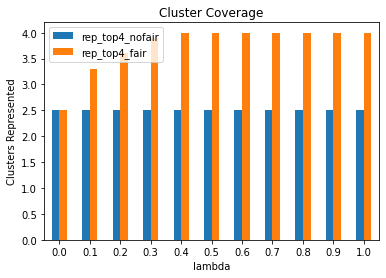

In [166]:
columns = ['lambda','rep_top4_nofair','rep_top4_fair']
coverage = statistics[columns]
coverage['lambda'] = coverage['lambda'].apply(lambda x : np.round(x,2))
coverage[['rep_top4_nofair','rep_top4_fair']]= coverage[['rep_top4_nofair','rep_top4_fair']].astype(str).astype(int)
coverage = coverage.groupby(['lambda']).mean()
fig = coverage.plot.bar(rot= 0)
plt.title('Cluster Coverage')
plt.xlabel('lambda')
plt.ylabel('Clusters Represented')
plt.savefig('Cluster Coverage.png')

Plotting rank relations

<ipython-input-170-654a6e8eb56c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relations ['lambda'] = relations ['lambda'].apply(lambda x : np.round(x,2))


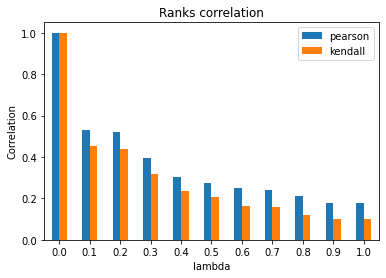

In [170]:
columns = ['lambda','p_rank_corr', 'k_rank_corr']
relations = statistics[columns]
relations ['lambda'] = relations ['lambda'].apply(lambda x : np.round(x,2))
#coverage[columns]= coverage[columns].astype(str).astype(int)
relations  = relations .groupby(['lambda']).mean()
relations = relations.rename(columns={"p_rank_corr": "pearson", "k_rank_corr": "kendall"})
fig = relations .plot.bar(rot= 0)
plt.title('Ranks correlation')
plt.xlabel('lambda')
plt.ylabel('Correlation')
plt.savefig('Ranks correlation.png')